# Environment Setting

Step 1: upload entire "Structure Product (combined ver.)" folder to google drive\
Step 2: run the first code box below to mount to your google drive\
Step 3: paste the google drive path to "filepath = " below\
Step 4: click "Run all" and find output in "Output.xslx" in google drive\

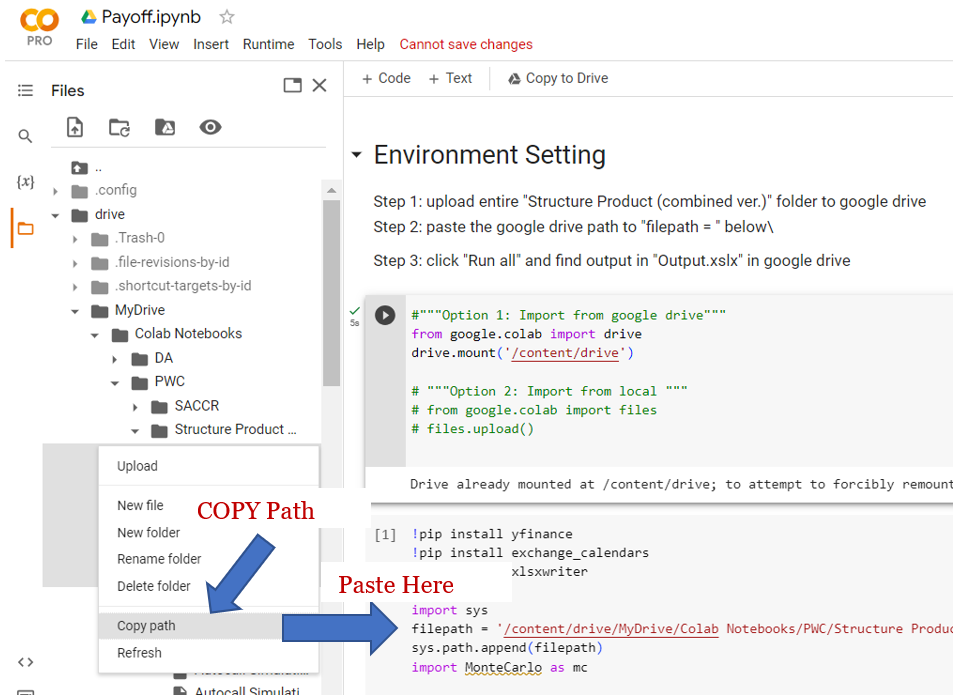

In [13]:

#"""Option 1: Import from google drive"""
### Mount to google drive ###
from google.colab import drive
drive.mount('/content/drive')

# """Option 2: Import from local """
# from google.colab import files
# files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip install yfinance
!pip install exchange_calendars
!pip install xlsxwriter

import sys
filepath = '/content/drive/MyDrive/Colab Notebooks/PWC/Structure Product Valuation/Structure Product (separated ver.)/'
sys.path.append(filepath)
import MonteCarlo as mc


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import exchange_calendars as xcals
import datetime as dt
import time
import openpyxl
import random
import os
from openpyxl.drawing.image import Image

#Payoff Calculation

**Call Event:** Occurs when Closing Price of Fixing Value is greater than or equal to its Callable Price on any Call Event Observation Date. When the Call Event occurs, Counterparty will pay BEA, on the Call Event Early Redemption Date any remaining Potential Coupon, which is accrued from and including the previous Coupon Payment Date (or effective date for the first coupon period) to but excluding the Call Event Early Redemption Date.


At maturity, provided that Call Event has never occurred before Determination Date: \
**M1**. The fixing price on the Determination Date is AT or ABOVE its Reference Price, BEA will receive the potential Coupon amount for the final coupon period.\
**M2**. The fixing price on the Determination Date is BELOW its Reference Price, BEA will receive (i) the potential coupon amount for the final Coupon Period, and (ii) a fixed number of shares of the reference stock calculated by reference to its Reference Price and Fractional Stock in notional currency based on the Closing Price on the Determination Date.


In [16]:
def seld_payoff(info,n_simulation = 100000,rf =.004):
  t0 = time.time()
  # get historical stock prices for simulation
  ticker = [info['tickers']]
  price_df = mc.get_stock_price(ticker,info['his_data_start'],info['his_data_end'])
  S0 = mc.get_stock_price(ticker,info['trade_date'],info['trade_date']+dt.timedelta(days=1) )

  # build calender
  xhkg = xcals.get_calendar("XHKG")
  # business date
  bd = xhkg.sessions_in_range(info['trade_date'], info['maturity_date'])
  # business dates in call period
  call_period= xhkg.sessions_in_range(info['call_obs_start'], info['call_obs_end'])

  T = len(bd) #length of simulation

  # Run simulation
  rt_0 = time.time()
  simu_df = mc.single_asset_simulation(T,price_df,rf,n_simulation,S0)
  print("Runtime for", n_simulation, "simulations is: ", time.time()-rt_0)

  call_price = (S0 * info['call_rate']).values  #call barrier prices -- array
  ref_price = (S0  * info['ref_rate']).values   #reference prices -- array

  # Calculate called coupon
  call_coupon_day_count =np.zeros(n_simulation)
  # Store which simulation has passed call barrier during the call observation period
  call_record = np.zeros(n_simulation)

  for n in range(n_simulation):
    for i in call_period:
      idx = bd.get_loc(i)
      # Check if the underlying stock crossed call barrier
      call_record[n] = simu_df[idx,n] >= call_price
      if call_record[n]:
        # if crossed call barrier -> early redemption -> calculate the coupon_accumulated days
        # call_record[n] = 1
        call_coupon_day_count[n] = (i-info['coupon_p1_start']).days #calender days
        break


  # Determine if stock price in determination day passed reference price
  determination_idx = bd.get_loc(info['determination_date'])
  pass_ref = simu_df[determination_idx,:] >= ref_price

  M1 = (1-call_record)*pass_ref   # call event never occured and pass reference price at maturity
  M2 = (1-call_record) *(1-pass_ref)

  #### Calculate Payoff ####
  day_count_basis = info['day_count_basis']
  coupon_rate = info['coupon_rate']
  deposit_amount = info['deposit_amount']

  # Payoffs for call event
  call_payoff = call_coupon_day_count/day_count_basis * coupon_rate*deposit_amount\
   * mc.discount_rate(call_coupon_day_count,rf,day_count_basis)

  # Payoffs for M1 event (See definition listed above)
  maturity_coupon_day_count = (info['coupon_p2_end'] - info['coupon_p1_start']).days
  M1_payoff = M1 * maturity_coupon_day_count/day_count_basis * coupon_rate * deposit_amount\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)

  # Payoffs for M2 event (See definition listed above)
  close_ref_ratio = simu_df[determination_idx,:]/ref_price
  M2_loss = M2 * deposit_amount*(1-close_ref_ratio)\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)

  M2_payoff = M2 * (maturity_coupon_day_count/day_count_basis * coupon_rate * deposit_amount )\
    *mc.discount_rate(maturity_coupon_day_count,rf,day_count_basis)

  pay_counter_date_count = call_coupon_day_count + maturity_coupon_day_count *(M1+M2)
  pay_counterparty =  pay_counter_date_count/day_count_basis * info['HIBOR'] *deposit_amount\
      *mc.discount_rate(pay_counter_date_count,rf,day_count_basis)


  coupon_earning = call_payoff + M1_payoff + M2_payoff
  pnl =  coupon_earning - pay_counterparty - M2_loss

  print("Total Runtime：", time.time()-t0)
  return coupon_earning, pnl, simu_df,price_df

# Write Output

In [17]:
def write_output(info, coupon_earning, pnl, simu_df,his_price, n_simulation,output_file):
  # write evaluation results to output file
  deposit_amount = info['deposit_amount']
  output_df = pd.DataFrame(columns = ['A'])

  output_df.loc['tickers'] = info['tickers']
  output_df.loc['referencing period'] = info['his_data_start'].strftime("%m/%d/%Y")+"-"+info['his_data_end'].strftime("%m/%d/%Y")
  output_df.loc['historical volatility'] = mc.get_volatility(his_price).values
  output_df.loc['simulated avg volatility'] = np.mean(mc.get_volatility(simu_df))
  output_df.loc['risk free rate'] = info['risk_free']
  output_df.loc['deposit amount'] = info['deposit_amount']
  output_df.loc['simulation'] = n_simulation
  output_df.loc['potential payoff'] = np.mean(coupon_earning)
  output_df.loc['potential P&L'] = np.mean(pnl)
  output_df.loc['maximum loss'] = np.min(pnl)
  output_df.loc['maximum profit'] = np.max(pnl)
  output_df['B'] = [" "]*7+(output_df.iloc[7:,0].values/deposit_amount).tolist()

  # # print plot
  plt.figure(figsize=(10,9))
  plt.subplot(2,2,1)
  mc.print_stock_plot(info['tickers'],his_price,"Historical Stock Path")
  plt.xticks(rotation = 15)
  plt.subplot(2,2,2)
  final_price = simu_df[-1,:]
  plt.hist(final_price,bins =50,color = 'orange')
  plt.axvline(simu_df[0,0], label = "Initial Price", linestyle="--",color = 'k')
  plt.axvline(np.mean(final_price), label = "Mean Final Price", linestyle="--",color = 'r')
  plt.title("Stimulated Stock Price on Valuation Date")
  plt.legend()
  plt.subplot(2,2,3)
  plt.hist(pnl.T)
  plt.gca().set(title='P&L Frequency Histogram', ylabel='Frequency',xlabel='P&L');
  plt.subplot(2,2,4)
  simu_price_avg = np.mean(simu_df,axis = 1)
  mc.print_stock_plot(info['tickers'],simu_price_avg,"Simulated path (avg)")
  p1 = plt.savefig("myplot.png", dpi = 60)

  strike_price = (simu_df[0,0] * info['call_rate'])
  # print randomly selected simulated paths
  plt.figure(figsize=(10,9))
  random_path = random.sample(range(n_simulation),4)
  for i in range(4):
    plt.subplot(2,2,i+1)
    mc.print_stock_plot(info['tickers'],simu_df[:,random_path[i]].T,\
                        "Randomly Selected Paths: No."+str(random_path[i]),\
                        hori_line = [strike_price],hori_label = ['strike barrier'])
  p2 = plt.savefig("myplot2.png", dpi = 60)
  p1 = Image("myplot.png")
  p2 = Image("myplot2.png")

  return output_df,p1,p2

# Run Inputted Contract

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Runtime for 100000 simulations is:  0.34763646125793457
Total Runtime： 10.327020168304443
                                              A         B
tickers                                 1810.HK          
referencing period        04/01/2021-04/01/2022          
historical volatility                  0.400661          
simulated avg volatility               0.398358          
risk free rate                             0.01          
deposit amount                          8093750          
simulation                               100000          
potential payoff                   56945.571468  0.007036
potential P&L                     -106831.28569 -0.013199
maximum loss                    -2922305.347629 -0.361057
maximum profit                     27450.140072  0.003392
[*********************100%***********************]  1 of 1 completed
[******

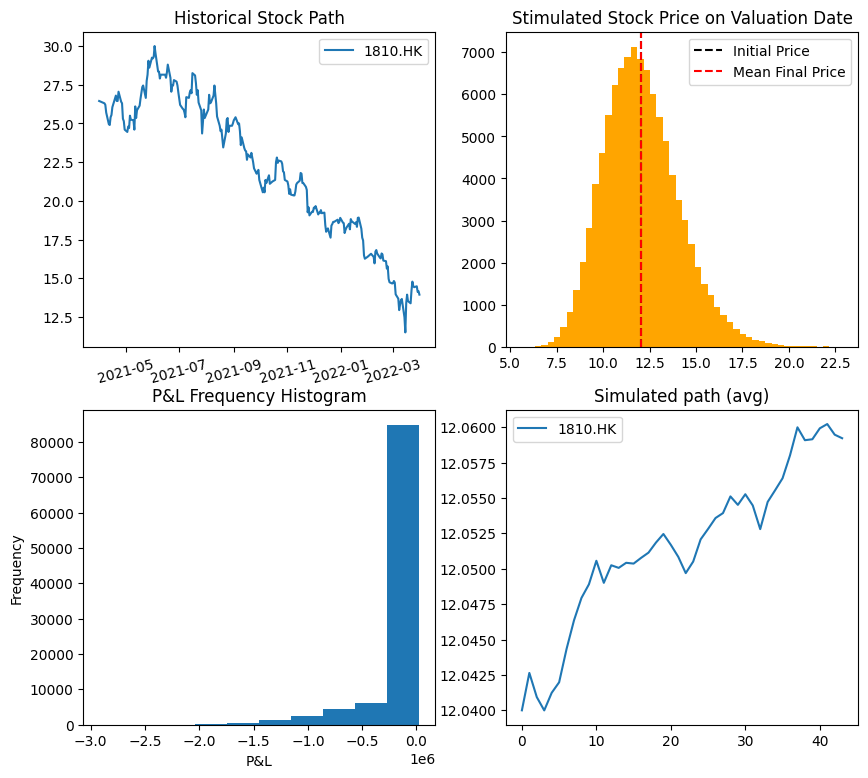

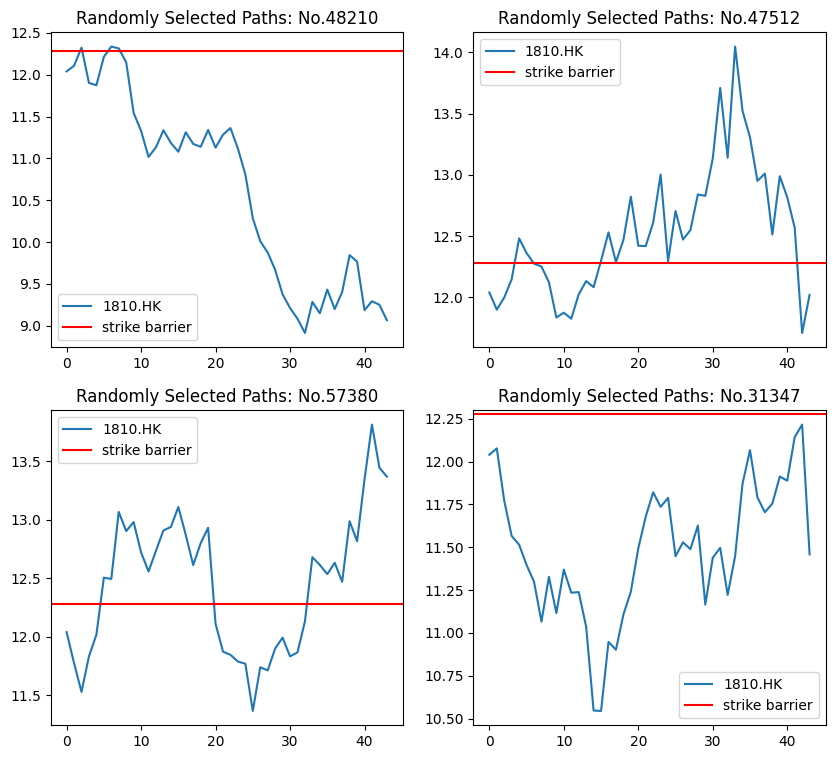

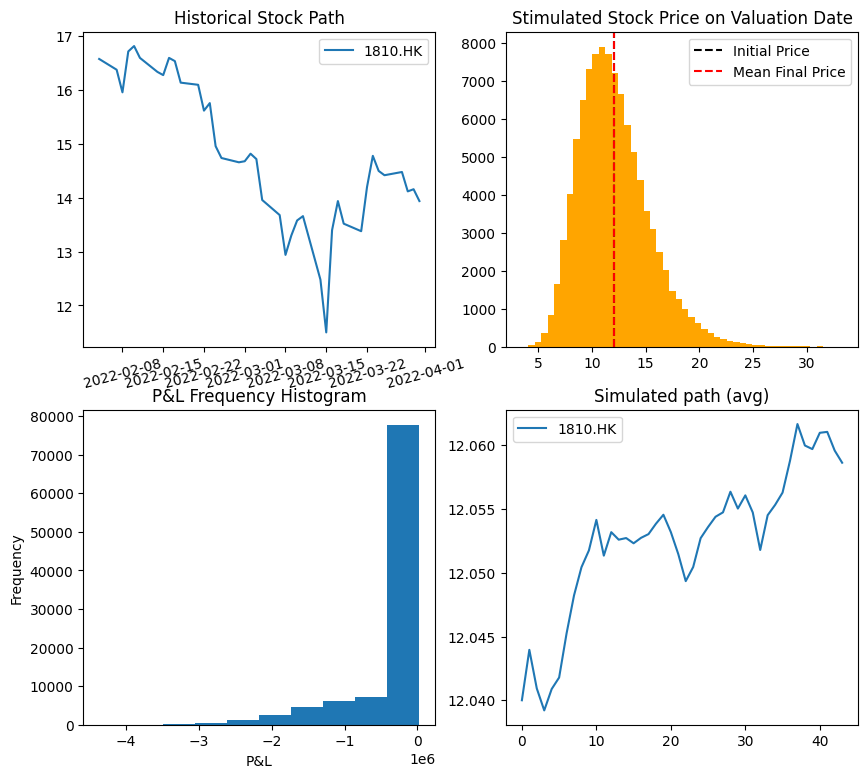

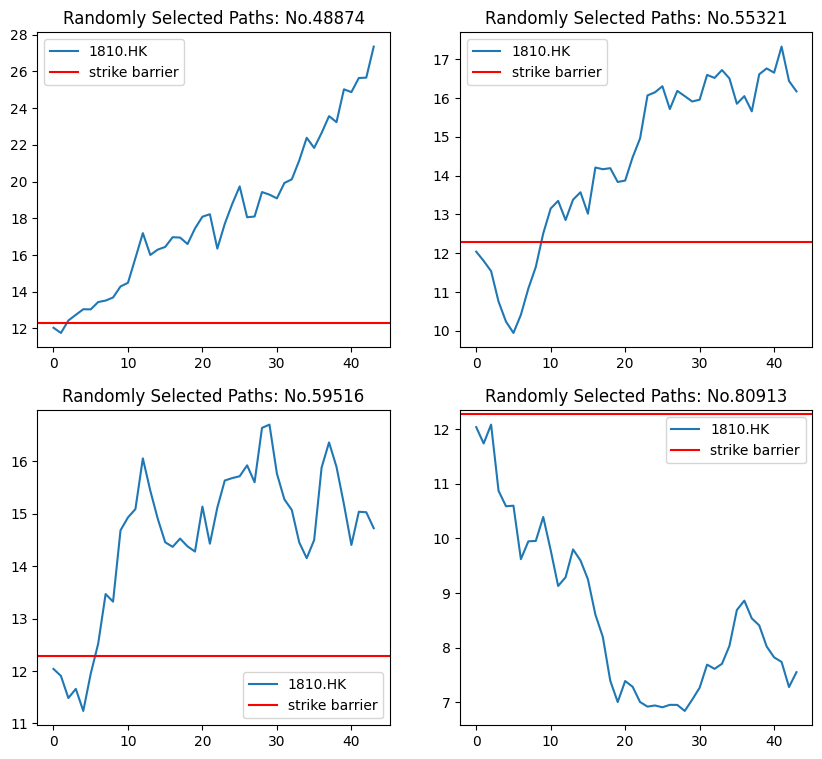

In [18]:
contract_df = pd.read_excel(filepath+'Input.xlsx',sheet_name='Single_Equity_Linked_Deposit')
contract = contract_df.to_dict('records')
n_record = len(contract)

# Create output file if it is not in the path
output_filepath = filepath + 'Output.xlsx'
if not os.path.isfile(output_filepath):
  wb = openpyxl.Workbook()
  wb.save(output_filepath)

# Loop over all contracts
for i in range(n_record):
  n_simulation,rf = contract[i]['n_simulation'],contract[i]['risk_free']

  # Run simulation for each contracts
  coupon_earning, pnl, simu_df,his_price = seld_payoff(contract[i],n_simulation,rf)

  # output_df= write_output(contract[i], coupon_earning, pnl, simu_df, \
  #                         his_price,n_simulation, output_filepath)


  output_df,p1,p2 = write_output(contract[i], coupon_earning, pnl, simu_df,\
                                his_price,n_simulation, output_filepath)
  print(output_df)

  # Load workbook and write result
  wb = openpyxl.load_workbook(output_filepath)
  sheet_name = contract[i]['contract']
  try:
    ws = wb[sheet_name]
  except KeyError:
    ws = wb.create_sheet(sheet_name)

  ws.add_image(p1,'E1')
  ws.add_image(p2,'E30')

  ws.column_dimensions['A'].width = 20
  ws.column_dimensions['B'].width = 20
  ws.column_dimensions['C'].width = 20

  wb.save(output_filepath)

  with pd.ExcelWriter(output_filepath, engine = 'openpyxl',mode="a",if_sheet_exists="overlay") as writer:
    output_df.to_excel(writer,sheet_name = contract[i]['contract'])

